# Homework 7 Template

Rixin Li & G . Besla



In [11]:
 # Make edits where instructed - look for "****", which indicates where you need to add code. 

In [26]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
from numpy.linalg import norm

# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 1200

# Computer Modern with TeX
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)

# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [27]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename):
        """
        Initializes our AnalyticOrbit object, storing the filename to write to,
        the M31 and M33 COM positions and velocities (incl. relative), and M31 halo,
        disk, and bulge masses and scale lengths.
        
        Inputs:
            filename : 'str'
                string filename to write our integrated orbit to
        
        Returns:
            None
        """

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        
        ### **** store the output file name
        self.filename = filename
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33
        # 2 = disk particles
        M33_com = CenterOfMass('M33_000.txt', 2)

        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        # tolerance of 0.1 kpc, reduce radius by factor of 4
        M33_com_p = M33_com.COM_P(0.1, 4)
        self.M33_com_p = M33_com_p.value
        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        # need units on position when calling COM_V
        M33_com_v = M33_com.COM_V(*M33_com_p)
        self.M33_com_v = M33_com_v.value
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        M31_com = CenterOfMass('M31_000.txt', 2)
        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        # tolerance of 0.1 kpc, reduce radius by factor of 2
        M31_com_p = M31_com.COM_P(0.1, 2)
        self.M31_com_p = M31_com_p.value
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        # need units on position when calling COM_V
        M31_com_v = M31_com.COM_V(*M31_com_p)
        self.M31_com_v = M31_com_v.value
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them be the
        # relative position and velocity VECTORS of M33
        self.r0 = self.M33_com_p - self.M31_com_p
        self.v0 = self.M33_com_v - self.M31_com_v
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5 # kpc

        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass('M31_000.txt', 2).value * 1e12
        
        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1 # kpc

        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass('M31_000.txt', 3).value * 1e12
        
        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 62 # kpc

        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass('M31_000.txt', 1).value * 1e12
    
    
    def HernquistAccel(self, M, r_a, r):
        """
        Computes the acceleration vector from a Hernquist potential,
        which we'll use for our bulges and halos.
        
        Inputs:
            M : 'float'
                Halo/bulge mass in MSun
            r_a : 'float'
                Hernquist profile scale length in kpc
            r : 'numpy array'
                Vector of floats, relative position to calculate the acceleration at
                (kpc)
        
        Returns:
            acc : 'numpy array'
                Vector of floats, acceleration vector due to the Hernquist potential
                (km/s/s)
        """
        
        ### **** Store the magnitude of the position vector
        rmag = norm(r)
        
        ### *** Store the Acceleration vector
        Hern = -self.G * M / (rmag * (r_a + rmag)**2) * r
        
        return Hern
    
    
    def MiyamotoNagaiAccel(self, M, r_d, r):
        """
        Computes the acceleration vector from a Miyamoto-Nagai profile,
        while we'll use for disks.
        
        Inputs:
             M : 'float'
                Disk mass in MSun
            r_d : 'float'
                Miyamoto-Nagai disk scale length in kpc
            r : 'numpy array'
                Vector of floats, relative position to calculate the acceleration at
                (kpc)
        
         Returns:
            acc : 'numpy array'
                Vector of floats, acceleration vector due to the Miyamoto-Nagai
                potential (km/s/s)
        """
        
        # Miyamoto-Nagai 1975 profile parameters
        z_d  = self.rdisk / 5.0
        z = r[2]
        R = norm(r[:-1])
        B = r_d + norm([z, z_d])
        
        # prefactor
        prefac = -self.G * M / norm([R, B])**3
        # put it all together
        acc = prefac * r * np.array([1, 1, B / norm([z, z_d])])
       
        return acc
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self, r):
        """
        Computes the total acceleration vector due to all three components of M31
        combined, at position vector r.
        
        Inputs:
            r : 'numpy array'
                Vector of floats, relative position to calculate the acceleration at
                (kpc)
            
        Returns:
            acc_sum : 'numpy array'
                Vector of floats, acceleration vector due to all three components of
                M31, at position r (km/s/s)
                
        """

        # Call the previous functions for the halo, bulge and disk
        acc_disk = self.MiyamotoNagaiAccel(self.Mdisk, self.rdisk, r)
        acc_halo = self.HernquistAccel(self.Mhalo, self.rhalo, r)
        acc_bulge = self.HernquistAccel(self.Mbulge, self.rbulge, r)
            
        # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        acc_sum = acc_disk + acc_halo + acc_bulge
        return acc_sum
    
    
    def LeapFrog(self, dt, r, v):
        """
        Integrates our galaxy COM equation of motion (d^2r/dt^2 = a) using a
        leapfrog integrator (second order, symplectic, etc. etc.)
        
        Inputs:
            dt : 'float'
                Time step (Gyr)
            r : 'numpy array'
                Vector of floats, relative position of M33 to M31 (kpc)
            v : 'numpy array'
                Vector of floats, relative velocity of M33 to M31 (km/s)
                
        Returns:
            rnew : 'numpy array'
                Vector of floats, updated relative position of M33 (kpc)
            vnew : 'numpy array'
                Vector of floats, update velocity of M33 (km/s)
            
        """
        
        # predict the position at the next half timestep
        rhalf = r + v * dt/2
        
        # predict the final velocity at the next timestep using the acceleration field at the rhalf position 
        vnew = v + self.M31Accel(rhalf)
        
        # predict the final position using the average of the current velocity and the final velocity
        # this accounts for the fact that we don't know how the speed changes from the current timestep to the 
        # next, so we approximate it using the average expected speed over the time interval dt. 
        rnew = rhalf + vnew * dt/2
        
        # return the new position and velocity vectors
        return rnew, vnew
            
    
    def OrbitIntegration(self, t0, dt, tmax):
        """
        Loops over the LeapFrog method in order to integrate the COM equation of motion
        for M33 around M31 from time t0 until time tmax with time step dt.

        Inputs:
            t0 : 'float'
                Start time for orbit integration (Gyr)
            dt : 'float'
                Time step (Gyr)
            tmax : 'float'
                End time for orbit integration (inclusive) (Gyr)

        """

        # initialize the time to the input starting time
        t = t0
        # initial position and velocity
        r = self.r0
        v = self.v0

        # initialize an empty array of size : rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros((int(tmax/dt)+2, 7))

        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]


        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1

        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while t < tmax:  # as long as t has not exceeded the maximal time 

            # **** advance the time by one timestep, dt
            t += dt
            # **** store the new time in the first column of the ith row
            orbit[i, 0] = t

            # ***** advance the position and velocity using the LeapFrog scheme
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
            rnew, vnew = self.LeapFrog(dt, r, v)

            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i, 1:4] = rnew

            # ****  store the new velocity vector into the columns with indexes 4,5,6 of the ith row of orbit
            orbit[i, 4:] = vnew

            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i += 1

            # Update position and velocity for the next run of the loop.
            r = rnew
            v = vnew
        
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%13.4f"*7, comments='#', 
                   header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                   .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))

# 5 &nbsp; Analysis

In [63]:
# Integration interval w/time step
t0 = 0.0 # Gyr
tmax = 10.0 # Gyr
dt = 0.01

filename = 'dt_0.01.txt'
M33_orbit = M33AnalyticOrbit(filename)
M33_orbit.OrbitIntegration(t0, dt, tmax)

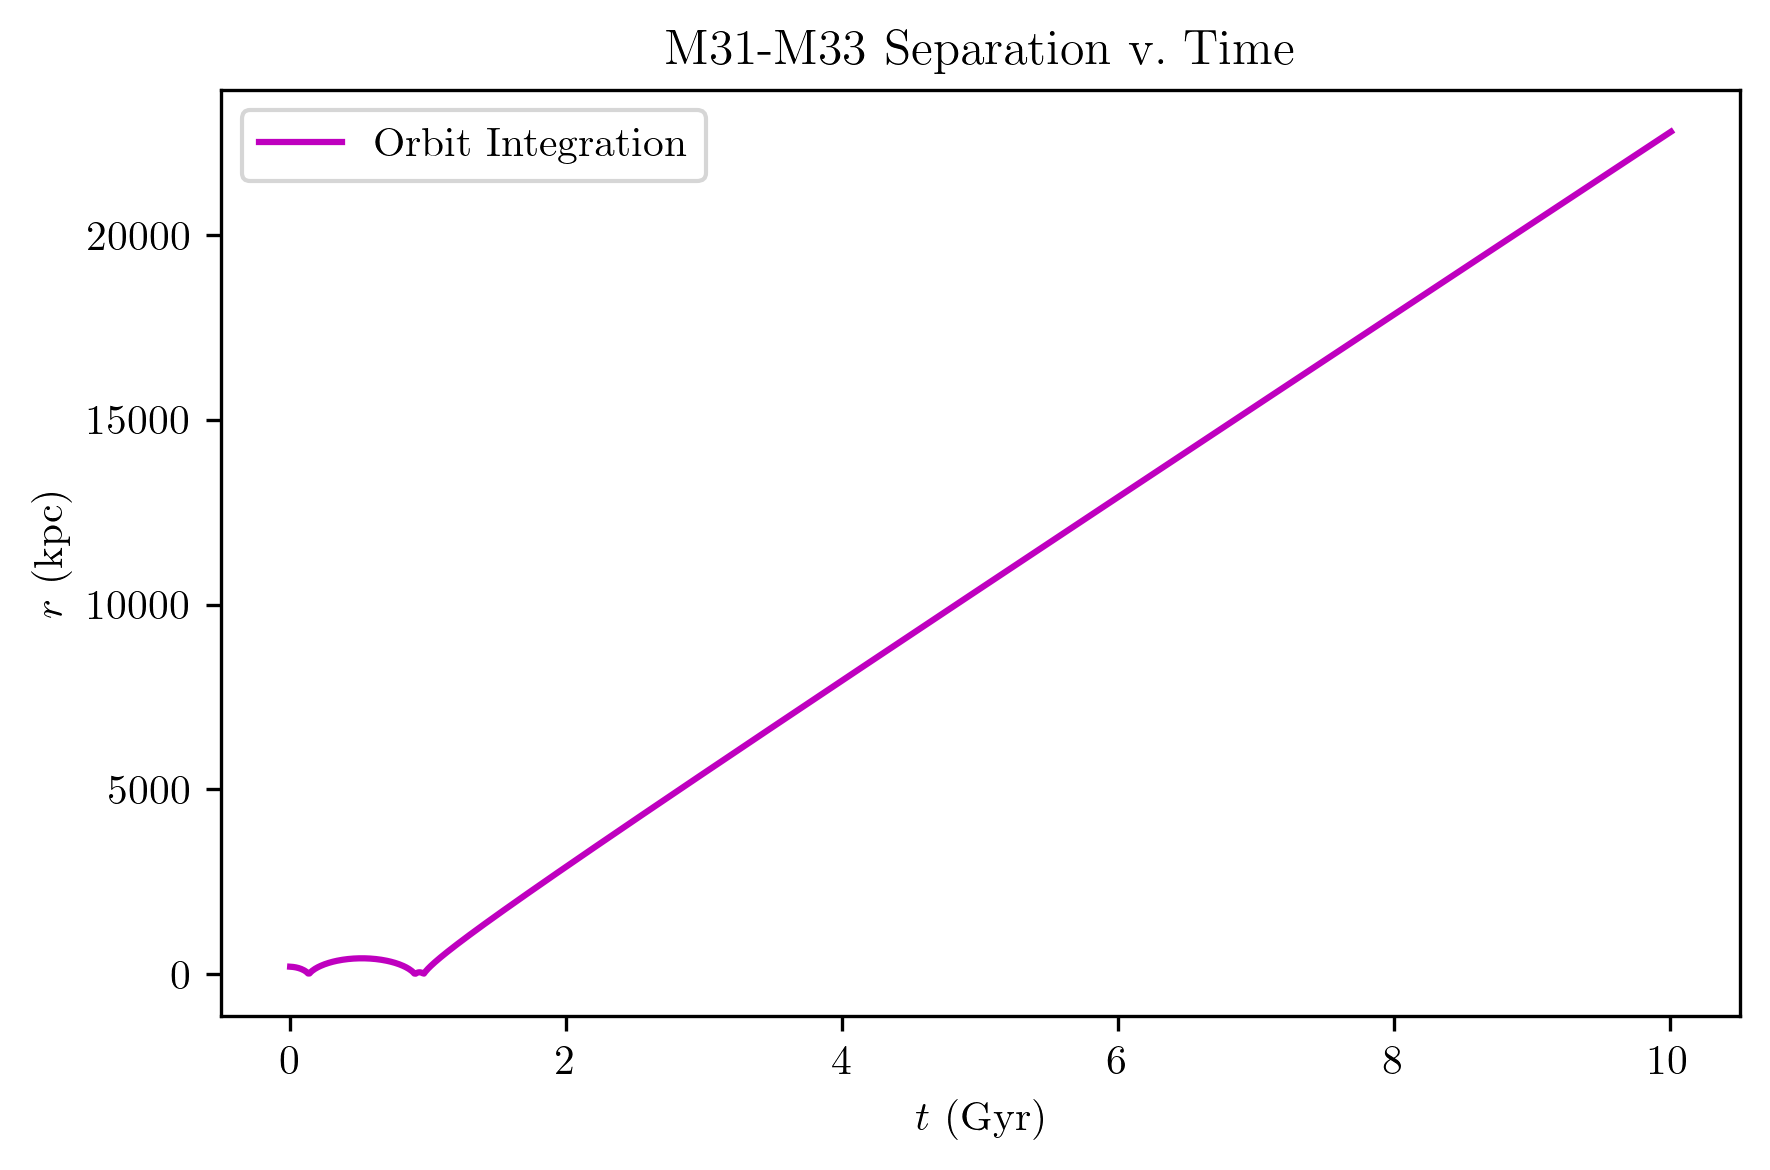

In [64]:
# Read in data
data = np.genfromtxt(filename, dtype=None, names=True)

t = data['t']
x = data['x']
y = data['y']
z = data['z']
vx = data['vx']
vy = data['vy']
vz = data['vz']

sim_data = np.genfromtxt()

r = np.sqrt(x**2 + y**2 + z**2)
v = np.sqrt(vx**2 + vy**2 + vz**2)

# Plot setup
fig, ax = plt.subplots()

ax.plot(t, r, color='m', label='Orbit Integration')
ax.set(title='M31-M33 Separation v.~Time', xlabel=r'$t$ (Gyr)', ylabel=r'$r$ (kpc)')

ax.legend()
fig.tight_layout()

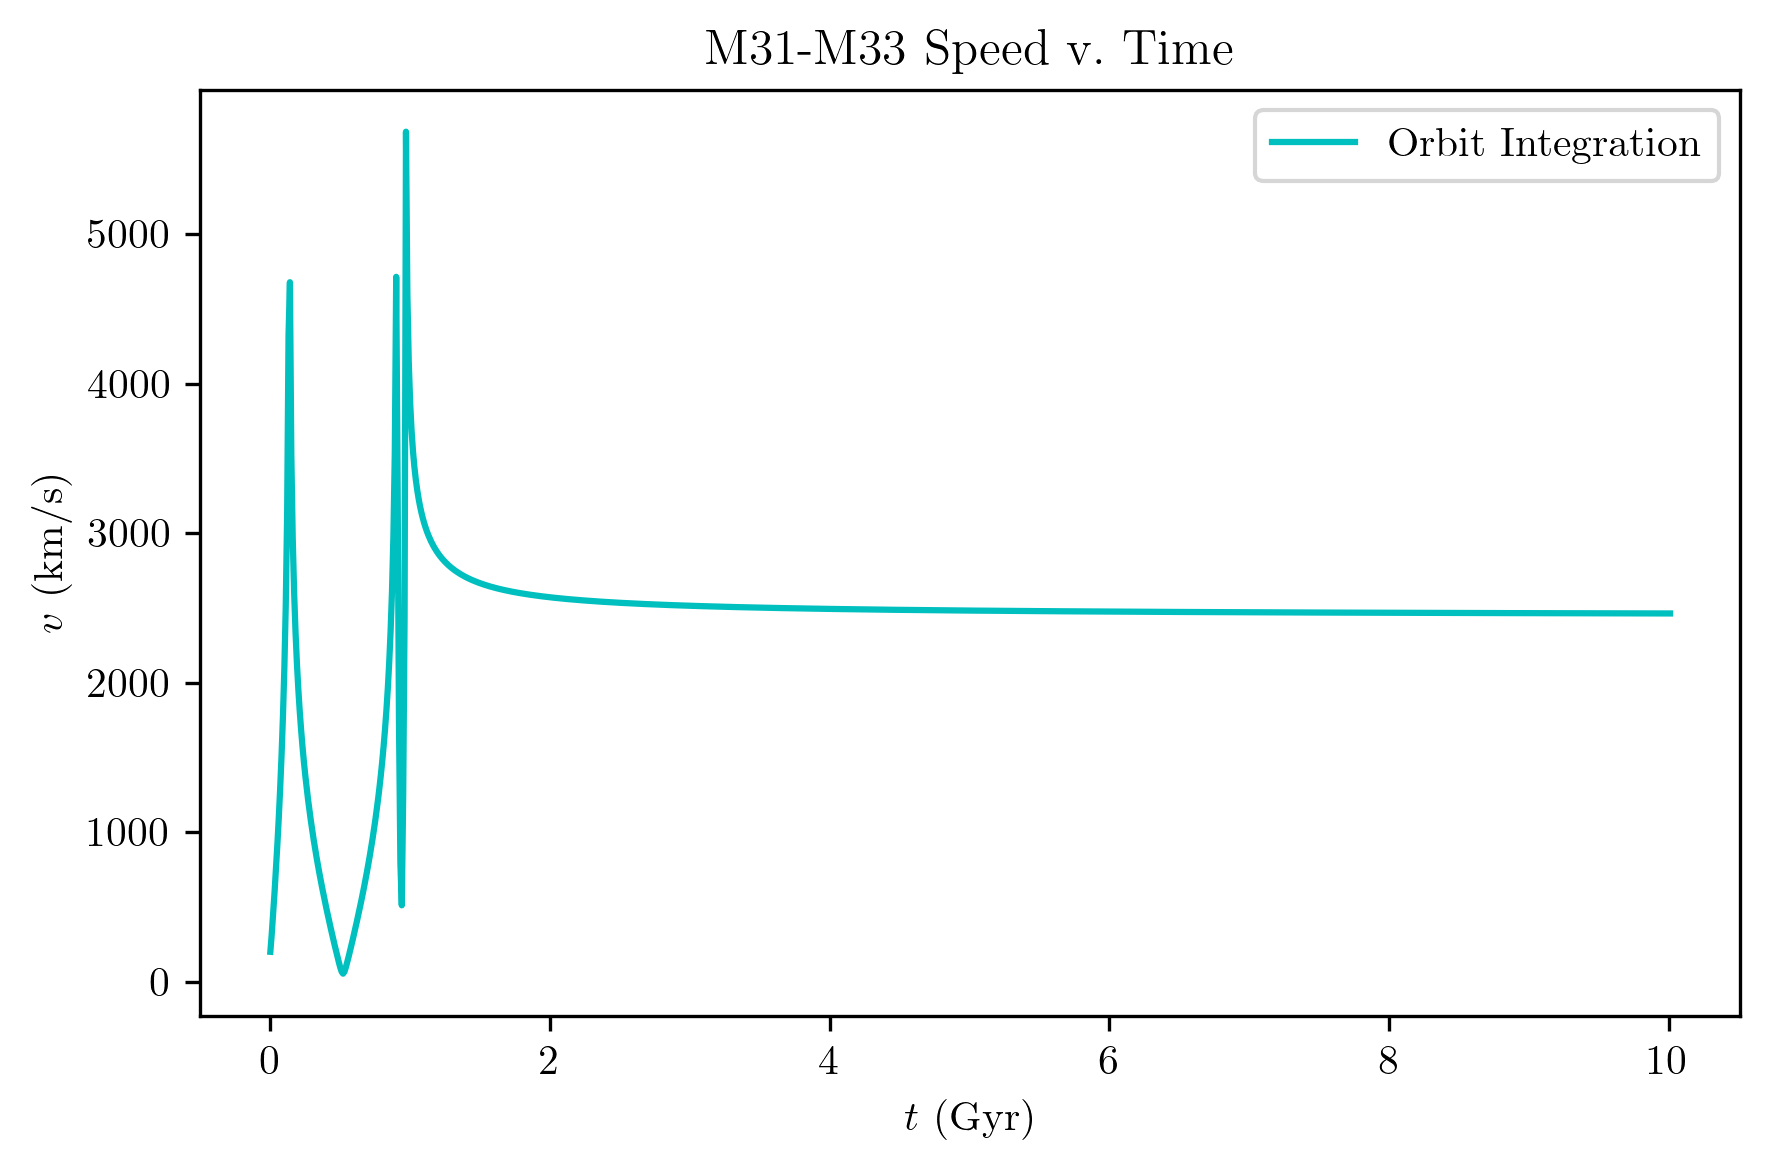

In [65]:
# Plot setup
fig, ax = plt.subplots()

ax.plot(t, v, color='c', label='Orbit Integration')
ax.set(title='M31-M33 Speed v.~Time', xlabel=r'$t$ (Gyr)', ylabel='$v$ (km/s)')

ax.legend()
fig.tight_layout()